In [9]:
import torch, math, os, sys, re, scipy
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
from scipy import signal
%matplotlib inline
sys.path.append("../..")
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data_org = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org/"

In [6]:
f_org = 200
def mat2df():
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        data = scipy.io.loadmat('/home/zhangyuanyuan/Dataset/data_MMECG/data_org/'+str(ID)+'.mat')
        Obj_ID= data['data'][0]['id'].squeeze()
        RCG = np.array([i for i in data['data'][0]['RCG']]).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID),RCG,
                                    ECG, posXYZ, gender, int(age), physistatus]
    return df
# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


In [7]:
df=mat2df() # read all the .mat file to dataframe


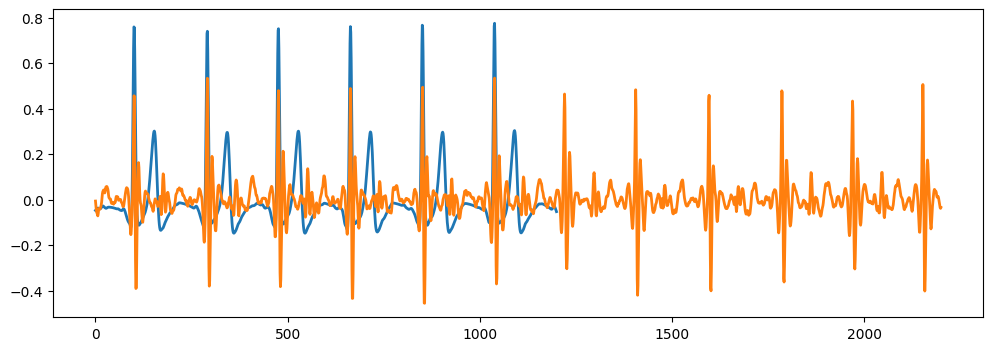

In [12]:
ID = 1
offset = 25
start = 0
end = 1500
radar_sig = df.RCG[ID][0][200:2400]
ecg = df.ECG[ID][200+offset:1400+offset]
radar_sig_T = butter_bandpass_filter(radar_sig, 20,25,f_org, order=6) #BPF for radar signal
radar_sig_R = butter_bandpass_filter(radar_sig, 5,15,f_org, order=6) #BPF for radar signal
# radar_sig_plot = radar_sig[start:end]
# radar_sig_R_plot = radar_sig_R[start+offset:end+offset]
plt.figure(figsize=(12,4))
plt.plot((ecg),linewidth=2)
plt.plot((radar_sig),linewidth=2)
plt.style.use('default')
# plt.plot((radar_sig_T),linewidth=2)
# plt.plot((radar_sig_R),linewidth=2)



In [ ]:
# coherent non-coherent in dynamic
# binary hypothesis test

ValueError: x and y must have same first dimension, but have shapes (401,) and (2200,)

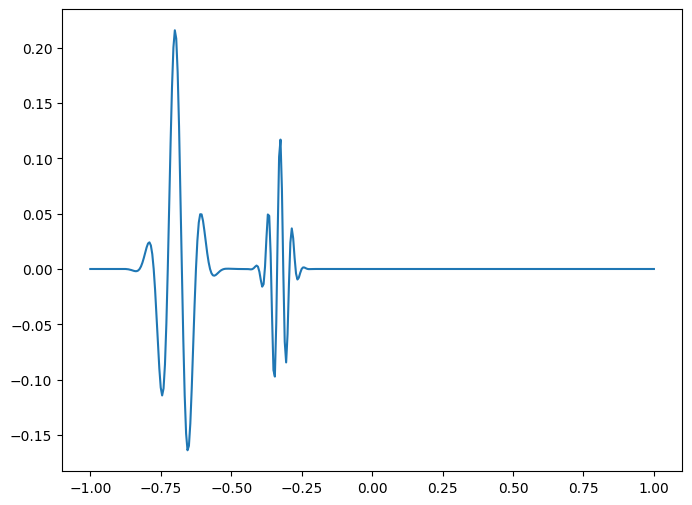

In [14]:
dt=.005
fs=1/dt
n=200*2
t=np.linspace(-n/2,n/2,n+1)*dt
a1=0.22
a2=0.12
mu_1=-0.69
mu_2=-0.33
sigma_1=0.05
variance_1=sigma_1**2
sigma_2=0.03
variance_2=sigma_2**2
f1 = 10
f2= 23
xt_1=np.cos(2*np.pi*t*f1)*a1*np.exp(-(t-mu_1)**2/(2*variance_1))
xt_2=np.cos(2*np.pi*t*f2)*a2*np.exp(-(t-mu_2)**2/(2*variance_2))
xt=xt_1-xt_2

plt.figure(figsize=(8,6))
plt.plot(t,xt,label='simulated signal')
plt.plot(t,radar_sig,label='radar signal')

### ECG ODE

In [2]:
def scale_output(input_params):
    # use input_params as the percentage range to scale the default_input
    default_input = np.array((
        ([5, 0.25, -15.0 * math.pi / 180.0,
          -100.0, 0.1, 25.0 * math.pi / 180.0,
          480.0, 0.1, 40.0 * math.pi / 180.0,
          -120, 0.1, 60.0 * math.pi / 180.0,
          8, 0.4, 135.0 * math.pi / 180.0]))).reshape((1, 15))
    default_input = torch.Tensor(default_input)
    input_params = (1+1*input_params) * default_input.to(device) # 2 is the factor for percentage
    # input_params = input_params.to(device)
    # input_params = default_input
    return input_params
def cross_entropy_loss(ecg_rcon, ecg_gts):
    loss = nn.CrossEntropyLoss()
    # ecg_rcon = ecg_rcon.squeeze(1)
    possi = ecg_gts.squeeze(1).softmax(dim=1)
    return loss(ecg_rcon, possi)
def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG

def norm_ecg11(ecg):
    k=2/(np.max(ecg)-np.min(ecg))
    ecg = -1+k*(ecg-np.min(ecg))
    return ecg

def down_sample(ecg, target_len=200):
    ecg = np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
def normal_ecg_torch11(ECG): 
    for itr in range(ECG.size(dim=0)):
        k=2/(torch.max(ECG[itr])-torch.min(ECG[itr]))
        ECG[itr] = -1+k*(ECG[itr]-torch.min(ECG[itr]))
    return ECG
def normal_ecg_torch(ECG):
    ECG = (ECG - torch.min(ECG)) / (torch.max(ECG) - torch.min(ECG))
    return ECG

In [31]:
train_path = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_new/train"
test_path = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_new/test"

# train_path = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_01_norm/train"
# test_path = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_01_norm/test"
ecgs_train=[]
ecgs_test=[]
pattern = 'ecg_seg'
for dirName, subdirList, fileList in os.walk(train_path):
    # print('Found directory: %s' % dirName)
    for fname in fileList:
        match2 = re.search(pattern, fname)
        if match2:
            ecg=down_sample(np.load(dirName+'/'+fname))
            ecg= norm_ecg(ecg)
            ecgs_train.append(ecg)
        # print(dirName)
for dirName, subdirList, fileList in os.walk(test_path):
    # print('Found directory: %s' % dirName)
    for fname in fileList:
        match2 = re.search(pattern, fname)
        if match2:
            ecg=down_sample(np.load(dirName+'/'+fname))
            ecg= norm_ecg(ecg)
            ecgs_test.append(ecg)
        # print(dirName)
print(len(ecgs_train),len(ecgs_test))

16564 2204


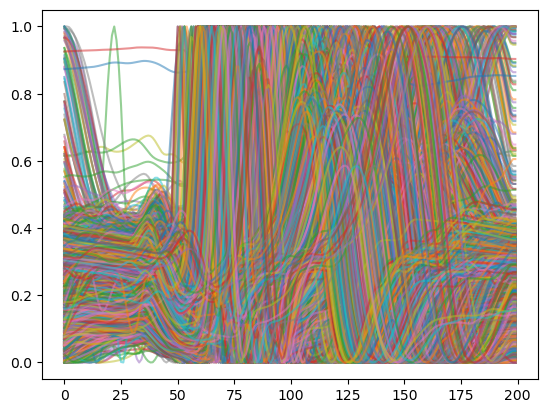

In [29]:
for i in range(1000):
    # plt.subplot(1,len(ECG_gts),i+1)
    ecg_gts=ecgs_train[i]
    # ecg_pred=valid_prediction[i].detach().cpu().numpy().squeeze()
    plt.plot((ecg_gts), alpha=0.5)

In [5]:
def scale_output(input_params):
    # use input_params as the percentage range to scale the default_input
    default_input = torch.Tensor((
        ([5, 0.25, -15.0 * math.pi / 180.0,
          -100.0, 0.1, 25.0 * math.pi / 180.0,
          480.0, 0.1, 40.0 * math.pi / 180.0,
          -120, 0.1, 60.0 * math.pi / 180.0,
          8, 0.4, 135.0 * math.pi / 180.0]))).reshape((1, 15))
    # default_input = torch.Tensor(default_input)
    input_params = (1+1*input_params) * default_input.to(device) # 2 is the factor for percentage
    # input_params = input_params.to(device)
    # input_params = default_input
    return input_params

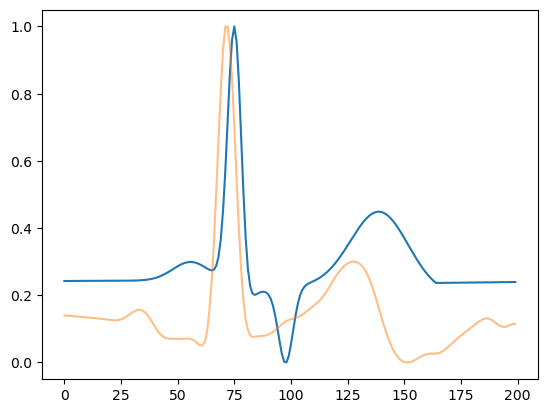

In [43]:
input = np.array((
        ([5, 0.25, -15.0 * math.pi / 180.0,
          -100.0, 0.1, 25.0 * math.pi / 180.0,
          480.0, 0.1, 40.0 * math.pi / 180.0,
          -120, 0.1, 60.0 * math.pi / 180.0,
          8, 0.4, 135.0 * math.pi / 180.0]))).reshape((1, 15))
# two batchs for example
a1 = torch.nn.Parameter(torch.Tensor(input), requires_grad=True)
a2 = torch.nn.Parameter(torch.Tensor(input), requires_grad=True)

input_params = torch.cat((a1, a2), 0)  # batch_size*15
z_signal = ode1_solver(input_params)
z_signal.size()
plt.plot(norm_ecg(z_signal[0].cpu().detach().numpy()))
plt.plot(norm_ecg(ecgs_train[100]), alpha=0.5)
plt.style.use('default')
# plt.savefig('solver_res.png')

In [30]:

a1=np.ones((1,15))*0
a2=np.ones((1,15))*-0.5
# two batchs for example
a1 = torch.nn.Parameter(torch.Tensor(a1), requires_grad=True)
a2 = torch.nn.Parameter(torch.Tensor(a2), requires_grad=True)

input_params = torch.cat((a1, a2), 0)  # batch_size*15
scale_output(input_params.to(device))

tensor([[ 5.0000e+00,  2.5000e-01, -2.6180e-01, -1.0000e+02,  1.0000e-01,
          4.3633e-01,  4.8000e+02,  1.0000e-01,  6.9813e-01, -1.2000e+02,
          1.0000e-01,  1.0472e+00,  8.0000e+00,  4.0000e-01,  2.3562e+00],
        [ 2.5000e+00,  1.2500e-01, -1.3090e-01, -5.0000e+01,  5.0000e-02,
          2.1817e-01,  2.4000e+02,  5.0000e-02,  3.4907e-01, -6.0000e+01,
          5.0000e-02,  5.2360e-01,  4.0000e+00,  2.0000e-01,  1.1781e+00]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [44]:
batchsize = 2
# Assuming ECG signals are 1D arrays of length 200
input_shape = (batchsize, 1, 200)

# Assuming we're trying to estimate 15 parameters
num_parameters = 15
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        return x

class ECGParameterEstimator(nn.Module):
    def __init__(self):
        super(ECGParameterEstimator, self).__init__()
        self.conv = nn.Sequential(
            # ConvBlock(1, 1, kernel_size=5, stride=1, padding=0),
            ConvBlock(1, 1, kernel_size=7, stride=2, padding=0),
            ConvBlock(1, 1, kernel_size=5, stride=1, padding=0),
            ConvBlock(1, 1, kernel_size=3, stride=2, padding=0),
            # ConvBlock(16, 8, kernel_size=5, stride=1, padding=0),
        )
        self.linear = nn.Sequential(
            # nn.Linear(200, 100),
            # # nn.BatchNorm1d(1),
            # nn.Dropout(),
            # # nn.ReLU(inplace=False),
            # nn.Tanh(),
            # nn.Linear(100, 50),
            # # nn.BatchNorm1d(1),
            # nn.Dropout(),
            # nn.Tanh(),
            # # nn.ReLU(inplace=False),
            # nn.Linear(50, 40),
            # # nn.BatchNorm1d(1),
            # # nn.Dropout(),
            # nn.Tanh(),
            # nn.ReLU(inplace=False),
            nn.Linear(46, 30),
            nn.Tanh(),
            nn.Linear(30, 28),
            nn.Tanh(),
            nn.Linear(28, 26),
            nn.Tanh(),
            nn.Linear(26, 24),
            nn.Tanh(),
            nn.Linear(24, 20),
            # nn.BatchNorm1d(1),
            # nn.Dropout(),
            # nn.ReLU(inplace=False),
            nn.Tanh(),
            nn.Linear(20, 200),
            # nn.BatchNorm1d(1),
            # nn.ReLU(inplace=False),
            nn.Tanh(),
        )
        # self.fc1 = nn.Linear(128*100, 256)
        # self.fc2 = nn.Linear(256, num_parameters)
    def _initialize_weights(self):
        for m in self.modules():
            # 判断是否属于Conv2d
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight.data)
                # 判断是否有偏置
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias.data, 0.3)
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0.1)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zeros_()
    def forward(self, x):
        x= self.conv(x)
        x = self.linear(x)
        # x = nn.functional.softmax(x, dim=1)
        return x

model = ECGParameterEstimator()
inputs= torch.randn(batchsize, 1, 200)
output = model(inputs)
print(summary(model, input_size=input_shape, device='cpu'))
print(output.min(), output.max())

Layer (type:depth-idx)                   Output Shape              Param #
ECGParameterEstimator                    [2, 1, 200]               --
├─Sequential: 1-1                        [2, 1, 46]                --
│    └─ConvBlock: 2-1                    [2, 1, 97]                --
│    │    └─Conv1d: 3-1                  [2, 1, 97]                8
│    │    └─BatchNorm1d: 3-2             [2, 1, 97]                2
│    │    └─ReLU: 3-3                    [2, 1, 97]                --
│    └─ConvBlock: 2-2                    [2, 1, 93]                --
│    │    └─Conv1d: 3-4                  [2, 1, 93]                6
│    │    └─BatchNorm1d: 3-5             [2, 1, 93]                2
│    │    └─ReLU: 3-6                    [2, 1, 93]                --
│    └─ConvBlock: 2-3                    [2, 1, 46]                --
│    │    └─Conv1d: 3-7                  [2, 1, 46]                4
│    │    └─BatchNorm1d: 3-8             [2, 1, 46]                2
│    │    └─ReLU: 3-9

In [45]:
import torch
from torch import nn
batchsize = 2
class ECGParameterEstimator(nn.Module):
    def __init__(self):
        super(ECGParameterEstimator, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),
            nn.Conv2d(16, 32, 3, stride=(1,2), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            nn.Conv2d(32, 64, 3, stride=(1,2), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.Conv2d(64, 64, 1, stride=(2,1), padding=(0,0)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, stride=(2,2), padding=(1,1), output_padding=1),
            nn.BatchNorm2d(32),
            # nn.Sigmoid(),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(32, 16, 5, stride=(2,2), padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(16, 8, 3, stride=(1,2), padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(8, 4, 3, stride=(1,1), padding=1, output_padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(4, 1, 1, stride=(1,1), padding=1, output_padding=0),
            nn.ReLU(inplace=False),
        )
        self.out_conv = nn.Sequential(
            nn.Conv1d(8, 4, kernel_size=7, stride=1, padding=1),
            nn.Conv1d(4, 2, kernel_size=5, stride=1, padding=1),
            nn.Conv1d(2, 1, kernel_size=4, stride=1, padding=0),
            nn.Conv1d(1, 1, kernel_size=1, stride=1, padding=0),
        )
        self.linear_out = nn.Sequential(
            nn.Linear(64*25, 1024,bias=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Linear(1024, 512,bias=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Linear(512, 256,bias=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Tanh(),
            nn.Linear(256, 128,bias=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 64,bias=True),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 32,bias=True),
            nn.BatchNorm1d(32),
            nn.Tanh(),
            nn.Linear(32, 16,bias=True),
            nn.BatchNorm1d(16),
            nn.Tanh(),
            nn.Linear(16, 15,bias=True),
            nn.Tanh(),
        )
        self.activation=nn.Tanh()
    def forward(self, x):
        x = self.encoder(x)
        # x = self.decoder(x).squeeze(1)
        # x = self.out_conv(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_out(x).unsqueeze(1)
        return x
    
model = ECGParameterEstimator()
input_shape = (batchsize, 1, 4, 200)
inputs= torch.randn(input_shape)
output = model(inputs)
print(summary(model, input_size=input_shape, device='cpu'))
print(output.min(), output.max())

Layer (type:depth-idx)                   Output Shape              Param #
ECGParameterEstimator                    [2, 1, 15]                65,906
├─Sequential: 1-1                        [2, 64, 1, 25]            --
│    └─Conv2d: 2-1                       [2, 16, 1, 99]            416
│    └─BatchNorm2d: 2-2                  [2, 16, 1, 99]            32
│    └─ReLU: 2-3                         [2, 16, 1, 99]            --
│    └─Conv2d: 2-4                       [2, 32, 1, 50]            4,640
│    └─BatchNorm2d: 2-5                  [2, 32, 1, 50]            64
│    └─ReLU: 2-6                         [2, 32, 1, 50]            --
│    └─Conv2d: 2-7                       [2, 64, 1, 25]            18,496
│    └─BatchNorm2d: 2-8                  [2, 64, 1, 25]            128
│    └─ReLU: 2-9                         [2, 64, 1, 25]            --
│    └─Conv2d: 2-10                      [2, 64, 1, 25]            4,160
│    └─BatchNorm2d: 2-11                 [2, 64, 1, 25]            12

In [46]:

# Instantiate the model
model = ECGParameterEstimator().to(device)
# model = RegressionTransformer(input_dim, output_dim, nhead, hidden_dim, num_layers).to(device)
data_tensor=torch.from_numpy(np.array(ecgs_train)).float()
data_tensor=data_tensor.unsqueeze(1)
# Define the loss function and the optimizer
criterion = nn.MSELoss()
criterion = cross_entropy_loss
# Create a DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor, data_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# dataloader.dataset.tensors[3].size()
data_tensor=torch.from_numpy(np.array(ecgs_test)).float()
data_tensor=data_tensor.unsqueeze(1)
dataset = TensorDataset(data_tensor, data_tensor)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [49]:
n_epochs = 30
learning_rate = 5e-3
lr_scheduler = 'cosine'
optimizer = 'sgd'
mse_loss_min = 1000000
train_loss_array = []
valid_loss_array = []
best_model = None
best_model_name = None

if optimizer == 'adamw':
    optimizer = optim.AdamW(lr=learning_rate, params=model.parameters(), weight_decay=5e-4)
else:
    optimizer = optim.SGD(lr=learning_rate, params=model.parameters(), weight_decay=5e-4, momentum=0.937)

if lr_scheduler == "cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, eta_min=learning_rate * 0.01, T_max=n_epochs/10)
elif lr_scheduler == "step":
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.9, step_size=1)
# Training loop
for epoch in range(n_epochs):
    train_loss = 0
    train_loop = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for batch_idx, (data, target) in train_loop:
        data=torch.stack([data,data,data,data],dim=2)
        # Forward pass
        target=(target).to(device)
        # data= torch.rand(input_shape)
        outputs = model(data.to(device)).to(device)
        scale_outputs = scale_output(outputs).squeeze(1).to(device)
        
        z_signal = ode1_solver(scale_outputs).to(device)
        # z_signal = (z_signal)
        # Compute loss
        loss = criterion(z_signal, target)
        # loss = criterion(outputs, target)
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ----------------------------------------------------- #
        train_loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
        train_loop.set_postfix(train_mse_loss=loss.item(), learning_rate=optimizer.param_groups[0]['lr'])
        train_loss+=loss.item()
    train_loss_array.append(train_loss)


    validation_loop = tqdm(enumerate(test_loader), total=len(test_loader))
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (data, target) in validation_loop:
            data=torch.stack([data,data,data,data],dim=2)
            target=(target).to(device)
            outputs = model(data.to(device)).to(device)
            scale_outputs = scale_output(outputs).squeeze(1).to(device)
            
            z_signal = ode1_solver(scale_outputs).to(device)
            
            # Compute loss
            loss = criterion(z_signal, target)
            # loss = criterion(outputs, target)
            validation_loss += loss.item()
            validation_loop.set_postfix(loss_real_time=loss.item(), test_mse_loss_total=
                                            validation_loss)

        if validation_loss < mse_loss_min:
            # mse_loss_min = loss.item()
            best_model = model
            best_model_name = 'Model_ode_solver.pth'
            print("best, vali_mse=",validation_loss/len(test_loader))
            torch.save(best_model.state_dict(), best_model_name)
            mse_loss_min = validation_loss
        else:
            cur_model = model
            cur_model_name = "cur_Model_ode_solver.pth"
            torch.save(cur_model.state_dict(), cur_model_name)
        valid_loss_array.append(validation_loss)
        scheduler.step()

    
# best_model = model
# best_model_name = 'Model_ode_solver.pth'
# torch.save(best_model.state_dict(), best_model_name)

100%|██████████| 35/35 [00:08<00:00,  4.26it/s, loss_real_time=5.3, test_mse_loss_total=185]  


best, vali_mse= 5.295646381378174


100%|██████████| 35/35 [00:08<00:00,  4.09it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.29072129385812


100%|██████████| 35/35 [00:08<00:00,  4.34it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.29050624029977


100%|██████████| 35/35 [00:08<00:00,  4.32it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.290158912113735


100%|██████████| 35/35 [00:09<00:00,  3.81it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.289463152204241


100%|██████████| 35/35 [00:07<00:00,  4.45it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.2890193666730605


100%|██████████| 35/35 [00:07<00:00,  4.38it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.288727828434536


100%|██████████| 35/35 [00:07<00:00,  4.40it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.288659885951451


100%|██████████| 35/35 [00:09<00:00,  3.80it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.288278715951102


100%|██████████| 35/35 [00:08<00:00,  4.25it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.288022109440395


100%|██████████| 35/35 [00:08<00:00,  4.34it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.287707792009626


100%|██████████| 35/35 [00:07<00:00,  4.40it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.287532683781215


100%|██████████| 35/35 [00:07<00:00,  4.39it/s, loss_real_time=5.29, test_mse_loss_total=185] 


best, vali_mse= 5.287067304338728


100%|██████████| 35/35 [00:09<00:00,  3.65it/s, loss_real_time=5.29, test_mse_loss_total=185] 

best, vali_mse= 5.287011459895543


In [48]:
scale_outputs.size()

torch.Size([64, 1, 15])

In [6]:
batch_size = 1
data_tensor=torch.from_numpy(np.array(ecgs_test)).float()
data_tensor=data_tensor.unsqueeze(1)
dataset = TensorDataset(data_tensor, data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
input_dim=2001 # dimension of signal index from -1 to 1
hidden_dim = 80 # dimension of embedding
num_layers = 6
output_dim=15
nhead=8
embed_dim=20 #dim of the signal_vector
state_dict_path="Model_ode_solver.pth"
state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_ode_solver.pth"
model = ECGParameterEstimator().to(device)
# model = RegressionTransformer(input_dim, output_dim, nhead, hidden_dim, num_layers).to(device)
# model._initialize_weights()
model.load_state_dict(torch.load(state_dict_path))

<All keys matched successfully>

In [21]:

valid_prediction=[]
output_visual=[]
ECG_gts=[]
ECG_pred=[]
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(dataloader):
        data=torch.stack([data,data,data,data],dim=2)
        outputs = model(data.to(device)).to(device).squeeze(1)
        scale_outputs = scale_output(outputs).to(device)
        z_signal = ode1_solver(scale_outputs).to(device)
        valid_prediction.append(z_signal)
        # valid_prediction.append(outputs)
        ECG_gts.append(target)
        output_visual.append(outputs)
        if i==100:
            break

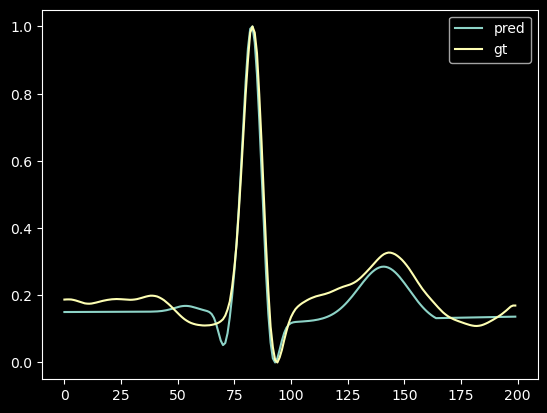

In [22]:
index=3
# print(output_visual[index])
ecg_pred=norm_ecg(valid_prediction[index][0].cpu().detach().numpy())
ecg_gts=(ECG_gts[index][0][0].cpu().detach().numpy())
plt.plot(ecg_pred, label='pred')
plt.plot(ecg_gts, label='gt')
# plt.plot(norm_ecg(z_signal[0].cpu().detach().numpy()), label='default')
plt.legend()
plt.style.use('default')

In [23]:
# calculate rmse error for data
rmses = np.array([])
mses = np.array([])
for i in range(0, len(ECG_gts)):
    ecg_gts=ECG_gts[i][0][0].detach().cpu().numpy().squeeze()
    ecg_pred=valid_prediction[i][0].detach().cpu().numpy().squeeze()[:200]
    factor = 1/(np.max(ecg_gts)-np.min(ecg_gts))
    ecg_min = np.min(ecg_gts)
    ecg_gts = norm_ecg(ecg_gts)
    ecg_pred = norm_ecg(ecg_pred)
    mse=mean_squared_error(ecg_gts/factor, ecg_pred/factor)
    mses = np.append(mses, (mse))
    rmses = np.append(rmses, np.sqrt(mse))
print("RMSE Mean:",np.mean(rmses),"Median:",np.median(rmses))
print(np.where(rmses==np.max(rmses)))
print(np.where(rmses==np.min(rmses)))

RMSE Mean: 0.0457797715126878 Median: 0.04223545268177986
(array([5]),)
(array([40]),)


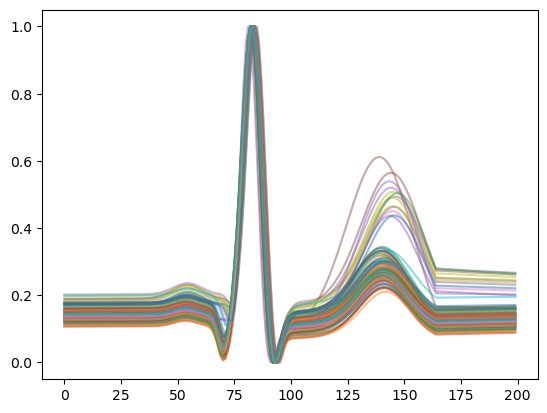

In [24]:
for i in range(len(ECG_gts)):
    # plt.subplot(1,len(ECG_gts),i+1)
    ecg_gts=ECG_gts[i][0][0].detach().cpu().numpy().squeeze()
    ecg_pred=valid_prediction[i].detach().cpu().numpy().squeeze()
    plt.plot(norm_ecg(ecg_pred), alpha=0.5)

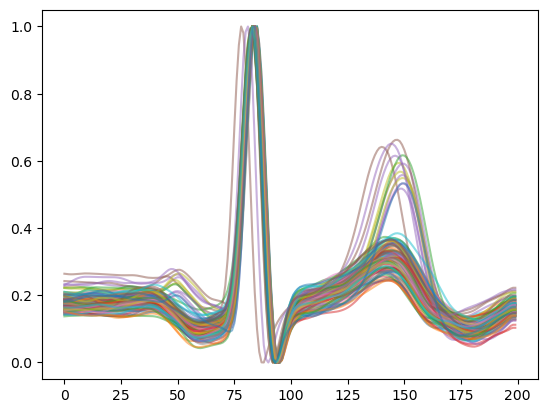

In [25]:
for i in range(len(ECG_gts)):
    # plt.subplot(1,len(ECG_gts),i+1)
    ecg_gts=ECG_gts[i][0][0].detach().cpu().numpy().squeeze()
    ecg_pred=valid_prediction[i].detach().cpu().numpy().squeeze()
    plt.plot(norm_ecg(ecg_gts), alpha=0.5)

NameError: name 'data_tensor' is not defined

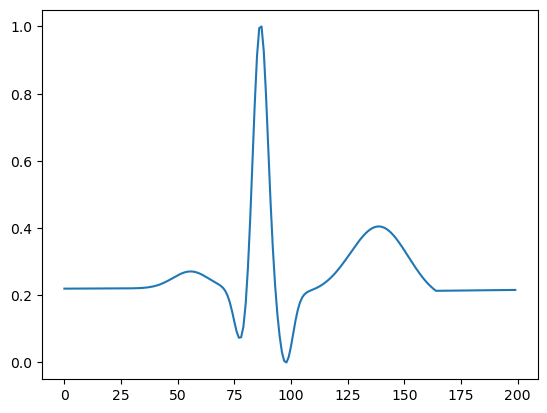

In [7]:
input = np.array((
        ([5, 0.25, -15.0 * math.pi / 180.0,
          -100.0, 0.1, 25.0 * math.pi / 180.0,
          480.0, 0.1, 40.0 * math.pi / 180.0,
          -120, 0.1, 60.0 * math.pi / 180.0,
          8, 0.4, 135.0 * math.pi / 180.0]))).reshape((1, 15))
# two batchs for example
a1 = torch.nn.Parameter(torch.Tensor(input), requires_grad=True)
a2 = torch.nn.Parameter(torch.Tensor(input), requires_grad=True)
input_params = torch.cat((a1, a2), 0)  # batch_size*15
z_signal = ode1_solver(input_params)
plt.plot(norm_ecg(z_signal[0].cpu().detach().numpy()))
plt.plot(data_tensor[index][0])
plt.style.use('default')
# plt.savefig('solver_res.png')